# Trying to implement spatio-temporal GP on south cascade glacier elevation data

## Installs

In [1]:
%pip install gpytorch
%pip install xarray
%pip install torch
%pip install matplotlib
%pip install urllib
%pip install xbatcher
%pip install dask
%pip install tqdm
%pip install git+https://github.com/friedrichknuth/gtsa.git 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/friedrichknuth/gtsa.git to /tmp/pip-req-build-1pifst9a
  Running command git clone --filter=blob:none --quiet https://github.com/friedrichknuth/gtsa.git /tmp/pip-req-build-1pifst9a
  Resolved https://github.com/friedrichknuth/gtsa.git to commit d8ee444da75b072f50668d6639fe4c5d66c89f8a
  Preparing meta

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

import torch
import gpytorch
from matplotlib import pyplot as plt
import urllib.request
import os
import pandas as pd
import numpy as np
import xarray as xr
import xbatcher
from dask.distributed import Client, LocalCluster
import psutil
import logging
import tools
import gtsa

%matplotlib inline

# the autoreload magic command above makes changes to dev functions put in tools.py 
# immmidiately available in the notebook without restarting the kernel.

# relevant functions put in tools.py can be transferred to a common or upstream library 
# later on during the hackweek.

In [5]:
cluster = LocalCluster(
    n_workers = psutil.cpu_count(logical=True)-1,
    silence_logs = logging.ERROR,
    threads_per_worker = 1,
)
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42127 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/e-marshall/proxy/42127/status,
Dashboard: /user/e-marshall/proxy/42127/status,Workers: 3
Total threads: 3,Total memory: 30.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45597,Workers: 3
Dashboard: /user/e-marshall/proxy/42127/status,Total threads: 3
Started: Just now,Total memory: 30.90 GiB
Comm: tcp://127.0.0.1:32883,Total threads: 1
Dashboard: /user/e-marshall/proxy/42935/status,Memory: 10.30 GiB
Nanny: tcp://127.0.0.1:38311,


In [6]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

In [7]:
#baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True})
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True})

### Dataset overview

In [8]:
scg_sub = gtsa.geospatial.extract_dataset_center_window(scg_ds, size=100)

Dataset center: 643993.428, 5358023.985
Test column size: 200.0 by 200.0 in spatial coordinate units.
No CRS defined.
Using xarray slicing to select data along spatial coordinate axes.


/srv/conda/envs/notebook/lib/python3.10/site-packages/gtsa/geospatial.py:78: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  xmode = np.abs(scipy.stats.mode(ds["y"].diff("y"))[0])
/srv/conda/envs/notebook/lib/python3.10/site-packages/gtsa/geospatial.py:79: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

In [9]:
scg_sub

<xarray.Dataset>
Dimensions:      (time: 71, y: 101, x: 101)
Coordinates:
  * time         (time) datetime64[ns] 1958-08-13 1967-09-21 ... 2021-08-13
  * x            (x) float64 6.439e+05 6.439e+05 ... 6.441e+05 6.441e+05
  * y            (y) float64 5.358e+06 5.358e+06 ... 5.358e+06 5.358e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(71, 51, 51), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:      Area
    TIFFTAG_ARTIST:     U.S. Geological Survey Benchmark Glacier Program
    TIFFTAG_COPYRIGHT:  Public Domain
    add_offset:         0.0
    crs:                PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM[...
    scale_factor:       1.0

In [10]:
scg_sub.nbytes/1e6

2.899276

### Plot bounds on interactive map

In [11]:
#baker_gdf = tools.bounds2polygon(*baker_ds.rio.bounds(),baker_ds.rio.crs)
#baker_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
#               attr='Google')

scg_gdf = tools.bounds2polygon(*scg_sub.rio.bounds(),scg_sub.rio.crs)
scg_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                attr='Google')

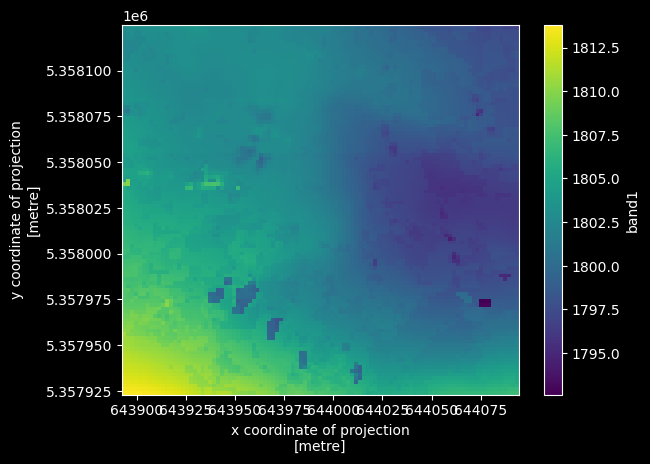

In [14]:
scg_sub.mean(dim='time').band1.plot();

In [29]:
#tools.plot_percent_area_coverage(baker_ds, 'mount baker \n percent DEM area coverage')

In [14]:
#tools.plot_percent_area_coverage(scg_ds, title = 'south cascade glacier -- percent DEM area coverage')

## Prepare subset of data to try GP 

In [15]:
def swap_time_dim(ds):
    ds['time_numeric'] = ds.time.dt.year + ds.time.dt.dayofyear / 365
    ds = ds.swap_dims({'time':'time_numeric'})
    return ds

def prep_data_to_tensor(ds):
    
    #ds = swap_time_dim(ds)

    
    x = ds.coords['x'].data
    y = ds.coords['y'].data
    t = ds.coords['time_numeric'].data
    z = ds.band1.data
    
    xv, yv,tv = torch.meshgrid(torch.from_numpy(x),
                        torch.from_numpy(y),
                        torch.from_numpy(t), indexing = 'ij')
    zv = torch.from_numpy(z)
    
    train_x = torch.cat(( #concatenates given seq of tensors in a given dim
    xv.contiguous().view(xv.numel(), 1), #returns contiguous in mem array, view rehsapes and numel returns # elements -- so this is like np reshape to 1xlen
    yv.contiguous().view(yv.numel(), 1),
    tv.contiguous().view(tv.numel(), 1)),
    dim=1 #dim to pass to cat
    )
    train_y = zv
    
    return (train_x, train_y)

## Select points on map

In [19]:
tools.select_points_on_map(baker_gdf,
                           output_file_name = 'baker_points.geojson')


In [7]:
import geopandas as gpd
baker_points_gdf = gpd.read_file('baker_points.geojson')

In [8]:
points = tools.extract_linestring_coords(baker_points_gdf.to_crs(baker_ds.rio.crs)['geometry'][0])
count_da = baker_ds['band1'].count(axis=0).compute()


In [13]:
#size in gb
count_da.nbytes/1e9

1.100872696

In [15]:
count_da_sub = count_da.isel(x = slice(3000,9000), y=slice(3000,9000))

In [16]:
count_da_sub.nbytes/1e9

0.288

In [17]:
std_da = baker_ds['band1'].count(axis=0).compute()

In [18]:
std_da_sub = std_da.isel(x=slice(3000,9000), y=slice(3000,9000))

In [ ]:
tools.xr_plot_count_std_glacier(count_da_sub,
                                std_da_sub,
                                points=points,
                                points_cmap = 'cool',
                                alpha = 0.8,
                                count_vmax=len(scg_ds.time));

## GP prep

In [16]:
scg_sub = swap_time_dim(scg_sub)

In [18]:
int(np.ceil(len(scg_sub.time_numeric)/2))

36

In [19]:
def format_chunks(ds):
    
    bgen = iter(xbatcher.BatchGenerator(ds, {'x':50,
                                             'y':50, 
                                             'time_numeric':int(np.ceil(len(ds.time_numeric)/2))},
                                            input_overlap={'time_numeric':9}
                                       ))
    chunk = next(bgen)
    return chunk
                

In [20]:
scg_chunk = format_chunks(scg_sub)

In [21]:
scg_chunk

<xarray.Dataset>
Dimensions:       (time_numeric: 36, y: 50, x: 50)
Coordinates:
    time          (time_numeric) datetime64[ns] 1958-08-13 ... 2016-01-06
  * x             (x) float64 6.439e+05 6.439e+05 ... 6.44e+05 6.44e+05
  * y             (y) float64 5.358e+06 5.358e+06 ... 5.358e+06 5.358e+06
  * time_numeric  (time_numeric) float64 1.959e+03 1.968e+03 ... 2.016e+03
Data variables:
    band1         (time_numeric, y, x) float32 1.856e+03 1.856e+03 ... 1.793e+03
    spatial_ref   int64 0
Attributes:
    AREA_OR_POINT:      Area
    TIFFTAG_ARTIST:     U.S. Geological Survey Benchmark Glacier Program
    TIFFTAG_COPYRIGHT:  Public Domain
    add_offset:         0.0
    crs:                PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM[...
    scale_factor:       1.0

Taking the third chunk because it was the first one with more than one time step of coverage

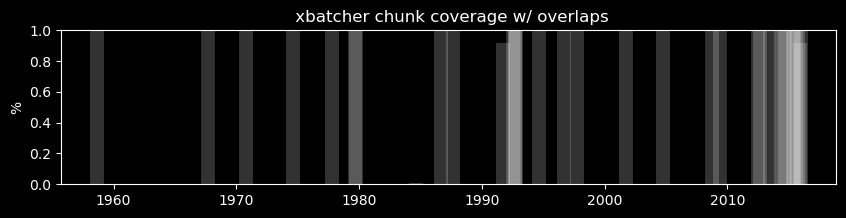

In [35]:
tools.plot_percent_area_coverage(scg_chunk, title = ' xbatcher chunk coverage w/ overlaps')


In [19]:
#format and generate test data (following george's code)
#train_x_chunk, train_y_chunk = prep_data_to_tensor(bgen[2])

In [22]:
data_chunk1 = scg_chunk.to_dataframe().dropna().reset_index().rename({'band1':'z'},axis=1).drop(['spatial_ref','time'],axis=1)

In [23]:
data_chunk1

,time_numeric,y,x,z
0,1958.616438,5358123.985,643893.428,1855.700806
1,1958.616438,5358123.985,643895.428,1856.378540
2,1958.616438,5358123.985,643897.428,1857.056274
3,1958.616438,5358123.985,643899.428,1857.734009
4,1958.616438,5358123.985,643901.428,1857.882690
...,...,...,...,...
82083,2016.016438,5358025.985,643983.428,1793.536865
82084,2016.016438,5358025.985,643985.428,1793.307739
82085,2016.016438,5358025.985,643987.428,1793.080444
82086,2016.016438,5358025.985,643989.428,1792.865967


## keenans example

In [24]:
def gaussian_2d(x,y,x0,y0,sigma_x, sigma_y, noise):
    z = torch.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return z + torch.normal(size=tuple(z.shape), mean=0.0, std=noise)

def make_test_dataset(size, bounds, x0, y0, sigma_x, sigma_y, noise):
    x = np.linspace(bounds[0], bounds[1], size)
    y = np.linspace(bounds[0], bounds[1], size)
    
    grid = torch.from_numpy(np.stack([x,y], axis=-1))
    xy = gpytorch.utils.grid.create_data_from_grid(grid)
    
    z = gaussian_2d(xy[:,0], xy[:, 1], x0,y0,sigma_x, sigma_y, noise)
    return grid.double(), xy.double(), z.double()


In [28]:
size  = 100
bounds = (-3,3)
x = np.linspace(bounds[0], bounds[1], size)
y = np.linspace(bounds[0], bounds[1], size)

grid = torch.from_numpy(np.stack([x,y], axis=-1))
xy = gpytorch.utils.grid.create_data_from_grid(grid)
z = gaussian_2d(xy[:,0], xy[:, 1], 0,0,1, 1, 0.5)

In [32]:
print(xy.shape)
print(z.shape)

torch.Size([10000, 2])
torch.Size([10000])


In [100]:
scg_x = scg_chunk.x.data
scg_y = scg_chunk.y.data
scg_z = scg_chunk.band1.mean(dim='time_numeric').data.

In [ ]:
files = [1,2,3,4,5,6,7,8,9,10]
training = files[:int(len(files)*0.8)] #[1, 2, 3, 4, 5, 6, 7, 8]
validation = files[-int(len(files)*0.1):] #[10]
testing = files[-int(len(files)*0.1):] #[10]


In [124]:
len(scg_xy)

2500

In [101]:
scg_grid = torch.from_numpy(np.stack([scg_x, scg_y], axis=-1))
scg_xy = gpytorch.utils.grid.create_data_from_grid(scg_grid)
scg_z = torch.from_numpy(scg_z.ravel())

In [104]:
scg_xy.shape

torch.Size([2500, 2])

In [102]:
scg_z.shape

torch.Size([2500])

In [89]:
scg_xy[:,0].shape
scg_z = torch.from_numpy(scg_z)

In [138]:
train_scg_xy = torch.from_numpy(scg_xy.numpy()[:int(len(scg_xy)*0.8)])
train_scg_z = torch.from_numpy(scg_z.numpy()[:int(len(scg_z)*0.8)])

In [137]:
test_scg_xy = torch.from_numpy(scg_xy.numpy()[-int(len(scg_xy)*0.2):])
test_scg_z = torch.from_numpy(scg_z.numpy()[-int(len(scg_z)*0.2):])


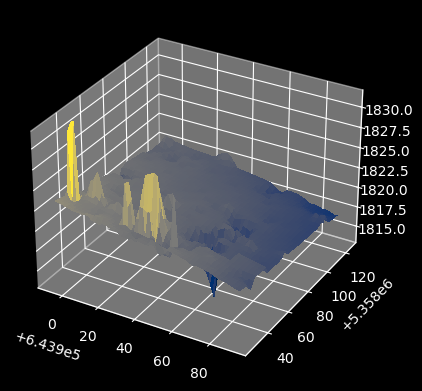

In [60]:
size=50
#grid, xy,z = make_test_dataset(size, (-3,3), 0,0,1,1,0.05)
                            
                            
shape = (size, size)
fig, ax = plt.subplots(subplot_kw = {'projection':'3d'})

surf = ax.plot_surface(
    scg_xy[:, 0].numpy().reshape(shape),
    scg_xy[:, 1].numpy().reshape(shape),
    scg_z, cmap='cividis',
    linewidth=0, antialiased=False)
plt.show()


In [105]:
import time as time
from tqdm import tqdm

# Gpytorch versions
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModelGrid(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(ExactGPModelGrid, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.MaternKernel(), grid=grid)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gpytorch_model(xy_tensor, z_tensor, use_structure=False, use_gpu=False, n_iter=10, grid=None):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if use_structure:
        model = ExactGPModelGrid(grid, xy_tensor, z_tensor, likelihood)
    else:
        model = ExactGPModel(xy_tensor, z_tensor, likelihood)

    # Transition to train mode
    model.train()
    likelihood.train()

    # Set up optimizter and log-likelihood
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    t0 = time.time()
    for _ in tqdm(range(n_iter)):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xy_tensor)
        # Calc loss and backprop gradients
        loss = -mll(output, z_tensor)
        loss.backward()
    tf = time.time()
    elapsed = tf - t0

    return model, likelihood, elapsed

In [106]:
print(type(scg_xy))
print(type(scg_z))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [147]:
model1 = train_gpytorch_model(train_scg_xy, train_scg_z)

100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


In [148]:
model2, likelihood2, time2 = train_gpytorch_model(train_scg_xy, train_scg_z, use_structure=True, grid=grid)

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


In [149]:
model2.eval()
likelihood2.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [150]:
model2.covar_module

GridKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
)

In [119]:
scg_xy

torch.Size([2500, 2])

In [114]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood2(model2(test_x))

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 2 but got size 1 for tensor number 1 in the list.

## gp example on gh

In [39]:
x_train = torch.tensor(data_chunk1['x'].values)
y_train = torch.tensor(data_chunk1['y'].values)
t_train = torch.tensor(data_chunk1['time_numeric'].values)
z_train = torch.tensor(data_chunk1['z'].values)

In [40]:
#code from ekin
# Partition full data into train and test sets. Do k fold cross validation on train set
# Use the first 80% of the data as the train set
def loadData(full_data, train_frac=0.8):
    train_data = full_data.iloc[:int(train_frac * full_data.shape[0])]
    test_data = full_data.iloc[int(train_frac * full_data.shape[0]):]

    # Train time
    train_time = torch.tensor(train_data['time_numeric'].values)
    train_x = torch.tensor(train_data['x'].values)
    train_y = torch.tensor(train_data['y'].values)
    train_elev = torch.tensor(train_data['z'].values)

    # Test time
    test_time = torch.tensor(test_data['time_numeric'].values)
    test_x = torch.tensor(test_data['x'].values)
    test_y = torch.tensor(test_data['y'].values)
    test_elev = torch.tensor(test_data['z'].values)

    # Stack train_time, train_x, train_y
    stacked_train = torch.stack([train_time, train_x, train_y], dim=1)

    # Stack test_time, test_x, test_y
    stacked_test = torch.stack([test_time, test_x, test_y], dim=1)

    # Cast as double
    stacked_train = stacked_train.double()
    train_elev = train_elev.double()
    stacked_test = stacked_test.double()
    test_elev = test_elev.double()

    return stacked_train, train_elev, stacked_test, test_elev

stacked_train, train_elev, stacked_test, test_elev = loadData(data_chunk1)

In [41]:
print(stacked_train.shape)
print(train_elev.shape)
print(stacked_test.shape)
print(test_elev.shape)

torch.Size([65670, 3])
torch.Size([65670])
torch.Size([16418, 3])
torch.Size([16418])


In [42]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

# Timing and math
import time
import math
import os
import psutil
import gc
process = psutil.Process(os.getpid())

In [51]:
## Define the Model
class BatchedGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, shape):
        super(BatchedGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([shape]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(batch_shape=torch.Size([shape])),
            batch_shape=torch.Size([shape])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [52]:
def train_gp_batched_scalar(Zs, Ys, use_cuda=False, epochs=10, lr=0.1):
    """Computes a Gaussian Process object using GPyTorch. Each outcome is
    modeled as a single scalar outcome.
    """
    # Preprocess batch data
    B, N, XD = Zs.shape  # B is batch dimension, N is points dimension, and XD is feature dimension
    YD = Ys.shape[-1]  # YD is target dimension
    
    # Convert features to tensor, and tile according to output targets
    train_x = torch.tensor(Zs)
    train_x = train_x.repeat((YD, 1, 1))
    
    # Convert targets to tensor, and reshape from (B, N, YD) --> (B * YD, N)
    train_y = torch.tensor(Ys)
    train_y = train_y.view(B * YD, N)

    # initialize likelihood and model - batch over output dimensions and batches
    likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([B * YD]))
    model = BatchedGP(train_x, train_y, likelihood, B * YD)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # If using GPU
    if use_cuda:
        model = model.cuda()
        likelihood = likelihood.cuda()
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        mll = mll.cuda()
    
    # Define training helper function
    def epoch_train():
        optimizer.zero_grad()  # Zero gradients
        output = model(train_x)  # Compute noise-free output
        loss = -mll(output, train_y).sum()  # Compute batched loss
        loss.backward()  # Compute gradients with backpropagation
        optimizer.step()  # Update weights with gradients
        optimizer.zero_grad()  # Zero gradients
        gc.collect()  # Used to ensure there is no memory leak
    
    # Run training
    for i in range(epochs):
        epoch_train()

    torch.cuda.empty_cache()
    return model, likelihood

## run training
with our model, likelihood and training routine defined, ready to train

In [60]:
train_y_np.shape

(256, 25, 1)

In [53]:
# Set parameters
B = 256  # Batch dimension
N = 25   # Number of points
XD = 2   # Dimension of features
YD = 1   # Dimension of targets
EPOCHS = 50
USE_CUDA = torch.cuda.is_available()

# Create training data and labels
train_x_np = np.random.normal(loc=0, scale=1, size=(B, N, XD))  # Create as np array
train_y_np = np.random.normal(loc=0, scale=1, size=(B, N, YD))  # Create as np array
train_x = torch.tensor(train_x_np).float()  # Can use .double() for 64-bit fp precision
train_y = torch.tensor(train_y_np).float()  # Can use .double() for 64-bit fp precision

# Time GPyTorch training
model, likelihood = train_gp_batched_scalar(train_x_np, train_y_np,
                        use_cuda=USE_CUDA, epochs=EPOCHS, lr=0.1)

# Calling .eval() places the model and likelihood in "posterior" mode
model.eval()
likelihood.eval()

# Define mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [84]:
model

BatchedGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [85]:
likelihood

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [86]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): BatchedGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [76]:
train_x_np_0 = np.squeeze(train_x_np[:,:,0:1])
train_x_np_1 = np.squeeze(train_x_np[:,:,1:2])

In [79]:
train_x_np_1.shape

(256, 25)

In [82]:
ha.plot_surface(train_x_np_0, train_x_np_1, np.squeeze(train_y_np))

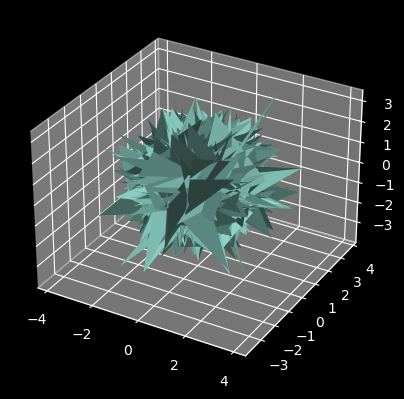

In [83]:
from mpl_toolkits.mplot3d import Axes3D

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(train_x_np_0, train_x_np_1, np.squeeze(train_y_np))

In [17]:
#setup model
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=3) # this will use same kernel on each dim
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4) #value + x,y,t derivative ? 


model = GPModelWithDerivatives(train_x_chunk, train_y_chunk, likelihood)

In [18]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

#optimize hyperparamters
model.train()

GPModelWithDerivatives(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): ConstantMeanGrad()
  (base_kernel): RBFKernelGrad(
    (raw_lengthscale_constraint): Positive()
  )
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernelGrad(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [19]:
likelihood.train()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [20]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x_chunk)
    loss = -mll(output, train_y_chunk)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f, %.3f  noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.covar_module.base_kernel.lengthscale.squeeze()[2],
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [6]:
baker_ds_sub = baker_ds.isel(y=slice(4500,6500), x=slice(6000,9000))

In [7]:
baker_sub_gdf = tools.bounds2polygon(*baker_ds_sub.rio.bounds(),baker_ds_sub.rio.crs)


In [8]:
baker_sub_gdf.explore()

In [9]:
#df['mid_date_numeric'] = df.index.year + df.index.day_of_year / 365
def swap_time_dim(ds):
    ds['time_numeric'] = ds.time.dt.year + ds.time.dt.dayofyear / 365
    ds = ds.swap_dims({'time':'time_numeric'})
    return ds
#baker_ds_sub['date_numeric'] = baker_ds_sub.time.dt.year + baker_ds_sub.time.dt.dayofyear / 365

In [10]:
def swap_time_dim(ds):
    ds['time_numeric'] = ds.time.dt.year + ds.time.dt.dayofyear / 365
    ds = ds.swap_dims({'time':'time_numeric'})
    return ds
baker_ds_sub = swap_time_dim(baker_ds_sub)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [11]:
baker_ds_sub

<xarray.Dataset>
Dimensions:       (time_numeric: 55, y: 2000, x: 3000)
Coordinates:
    time          (time_numeric) datetime64[ns] 1947-09-14 ... 2020-12-12
  * x             (x) float64 5.869e+05 5.869e+05 ... 5.899e+05 5.899e+05
  * y             (y) float64 5.405e+06 5.405e+06 ... 5.403e+06 5.403e+06
  * time_numeric  (time_numeric) float64 1.948e+03 1.951e+03 ... 2.021e+03
Data variables:
    band1         (time_numeric, y, x) float32 dask.array<chunksize=(55, 484, 30), meta=np.ndarray>
    spatial_ref   int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [50]:
def prep_data_to_tensor(ds):
    
    x = ds.coords['x'].data
    y = ds.coords['y'].data
    t = ds.coords['time_numeric'].data
    z = ds.band1.data.compute()
    
    xv, yv,tv = torch.meshgrid(torch.from_numpy(x),
                        torch.from_numpy(y),
                        torch.from_numpy(t), indexing = 'ij')
    zv = torch.from_numpy(z)
    
    train_x = torch.cat(( #concatenates given seq of tensors in a given dim
    xv.contiguous().view(xv.numel(), 1), #returns contiguous in mem array, view rehsapes and numel returns # elements -- so this is like np reshape to 1xlen
    yv.contiguous().view(yv.numel(), 1),
    tv.contiguous().view(tv.numel(), 1)),
    dim=1 #dim to pass to cat
    )
    train_y = zv
    
    return (train_x, train_y)
    #return({'x':x, 'y':y, 'time':t,'z':z})

In [12]:
x = baker_ds_sub.coords['x'].data
y = baker_ds_sub.coords['y'].data
t = baker_ds_sub.coords['time_numeric'].data

In [13]:
z = baker_ds_sub.band1.data.compute()

In [40]:
2000*3000*55

330000000

In [14]:
xv, yv,tv = torch.meshgrid(torch.from_numpy(x),
                        torch.from_numpy(y),
                        torch.from_numpy(t), indexing = 'ij')

In [15]:
zv = torch.from_numpy(z)

In [16]:
zv.shape

torch.Size([55, 2000, 3000])

In [17]:
xv.shape
yv.shape
tv.shape

torch.Size([3000, 2000, 55])

In [18]:
train_x = torch.cat(( #concatenates given seq of tensors in a given dim
    xv.contiguous().view(xv.numel(), 1), #returns contiguous in mem array, view rehsapes and numel returns # elements -- so this is like np reshape to 1xlen
    yv.contiguous().view(yv.numel(), 1),
    tv.contiguous().view(tv.numel(), 1)),
    dim=1 #dim to pass to cat
)

In [21]:
type(train_x)

torch.Tensor

In [23]:
type(zv)

torch.Tensor

In [24]:
train_y = zv

In [32]:
train_x.shape

torch.Size([330000000, 2])

In [33]:
#setup model
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=3) # this will use same kernel on each dim
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4) #value + x,y,t derivative ? 
model = GPModelWithDerivatives(train_x, train_y, likelihood)

In [34]:
import os

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

#optimize hyperparamters
model.train()

GPModelWithDerivatives(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): ConstantMeanGrad()
  (base_kernel): RBFKernelGrad(
    (raw_lengthscale_constraint): Positive()
  )
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernelGrad(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [35]:
likelihood.train()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [36]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 

In [37]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [38]:
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f, %.3f  noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.covar_module.base_kernel.lengthscale.squeeze()[2],
        model.likelihood.noise.item()
    ))
    optimizer.step()

RuntimeError: Storage size calculation overflowed with sizes=[1320000000, 1320000000]

## example in gh issue

In [6]:
# data setup example

L = [i for i in range(20)]
A = [i for i in range(5)]
T = [i for i in range(30)]

In [24]:
L

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
def cartesian(*arrays):
    mesh = np.meshgrid(*arrays) 
    dim = len(mesh)
    elements = mesh[0].size
    flat = np.concatenate(mesh).ravel() #flatten mesh grid
    reshape = np.reshape(flat, (dim, elements)).T 
    return reshape

In [8]:
def cartesian(*arrays):
    mesh = np.meshgrid(*arrays) 
    dim = len(mesh)
    elements = mesh[0].size
    flat = np.concatenate(mesh).ravel() #flatten mesh grid
    reshape = np.reshape(flat, (dim, elements)).T 
    return reshape
def prep_data(name_list, *arrays):
    cartprod = cartesian(*arrays)
    dout = pd.DataFrame(cartprod)
    dout.columns = name_list
    return dout

In [11]:
dtt = prep_data(['L','A','T'], L,A,T)

In [25]:
dtt

,L,A,T,x1,x2,y
0,0,0,0,0.912498,0.815313,0.900489
1,0,0,1,0.019954,0.787148,0.416830
2,0,0,2,0.848768,0.158743,0.864775
3,0,0,3,0.714632,0.907067,0.562938
4,0,0,4,0.427587,0.267526,0.484298
...,...,...,...,...,...,...
2995,19,4,25,0.352169,0.420273,0.479850
2996,19,4,26,0.438640,0.282048,0.283001
2997,19,4,27,0.712919,0.437210,0.363307
2998,19,4,28,0.839065,0.659513,0.772225


In [12]:
#simulate random values
beta_x1 = 0.4
beta_x2 = 0.3
LL_noise = 0.25

In [13]:
dtt['x1'] = np.random.uniform(size=dtt.shape[0])
dtt['x2'] = np.random.uniform(size=dtt.shape[0])
dtt['y'] = beta_x1*dtt['x1'] + beta_x2*dtt['x2'] + np.random.normal(scale=LL_noise, size = dtt.shape[0])

In [17]:
train_x = torch.from_numpy(dtt[['x1','x2','L','A','T']].values.astype(np.double)).to(torch.float)
train_y = torch.from_numpy(dtt[['y']].values[:,0].astype(np.double)).to(torch.float)
test_x = torch.from_numpy(dtt[['x1','x2','L','A','T']].values.astype(np.double)).to(torch.float)

In [19]:
train_x.shape

torch.Size([3000, 5])

In [21]:
train_y.shape

torch.Size([3000])

In [23]:
test_x.shape

torch.Size([3000, 5])

### setup training data of spatial mean

In [111]:
import numpy as np
train_z_time_only = torch.from_numpy(z_time_only)
train_time = torch.from_numpy(time_int)

In [112]:
train_z_time_only.shape

torch.Size([29])

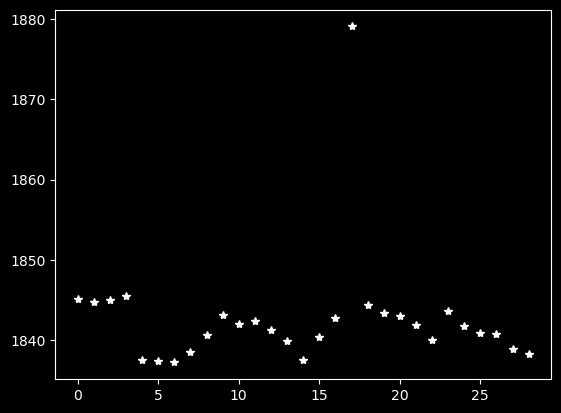

In [148]:
plt.plot(train_time.numpy(), train_z_time_only.numpy(), 'w*')

In [154]:
train_z_3d.shape

torch.Size([29, 1000, 1000])

## Build gp

In [224]:
class Kernel(gpytorch.kernels.Kernel):
    def __init__(self):
        super(Kernel, self).__init__()
        self.matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2), num_dims=3, active_dims=[0,1,2])
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(num_dims=3, active_dims=[0])
        #self.noise_kernel = gpytorch.kernels.WhiteNoiseKernel()
    def forward(self, x1, x2, **params):
        #    cov = kernel.forward(X, X).evaluate().detach().numpy()[0, :, :] <--- need to specify dims for each kernel doign something like this
        # from https://github.com/cornellius-gp/gpytorch/issues/526               but where forward called on kernel ? 
        matern_term = self.matern_kernel(x1, x2, **params)
        periodic_term = self.periodic_kernel(x1, x2, **params)
        return matern_term + periodic_term + WhiteNoiseKernel()

In [225]:
test_kernel = Kernel()

In [226]:
test_kernel

Kernel(
  (matern_kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (periodic_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
  )
)

In [57]:
class Kernel(gpytorch.kernels.Kernel):
    def __init__(self):
        super(Kernel, self).__init__()
        self.matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2), num_dims=3, active_dims=[0,1,2])
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(num_dims=3, active_dims=[0])
        #self.noise_kernel = gpytorch.kernels.WhiteNoiseKernel()
    def forward(self, x1, x2, **params):
        #    cov = kernel.forward(X, X).evaluate().detach().numpy()[0, :, :] <--- need to specify dims for each kernel doign something like this
        # from https://github.com/cornellius-gp/gpytorch/issues/526               but where forward called on kernel ? 
        matern_term = self.matern_kernel(x1, x2, **params)
        periodic_term = self.periodic_kernel(x1, x2, **params)
        return matern_term + periodic_term + WhiteNoiseKernel()

test_kernel = Kernel()

class GP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, time_train, likelihood):
        super(GP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.cov_time = test_kernel#.forward(x,x).evaluate().detach().numpy()[0,:,:]
        #then do something like the above for each dim ? 
        #self.cov.initialize_from_data(x_train, y_train)
        
    def forward(self, x1, x2):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 


In [58]:
#x_tensor, y_tensor_time_tensor

In [59]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = GP(x_tensor, y_tensor, time_tensor, likelihood)

NameError: name 'x_tensor' is not defined

In [229]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [203]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [211]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): GP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean): ConstantMean()
    (cov): Kernel(
      (matern_kernel): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (periodic_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
      )
    )
  )
)

In [210]:
n_iter = 50

for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model(train_time)
    # Compute loss and backprop gradients
    #loss = -mll(output, train_z_time_only) #failing on computing loss step
    #loss.backward()
    #print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    #optimizer.step()

MultivariateNormal(loc: torch.Size([29]))

In [194]:
model.eval()

GP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean): ConstantMean()
  (cov): Kernel(
    (matern_kernel): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (periodic_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
  )
)

In [195]:
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

# For testing

In [196]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix

NameError: name 'x_test' is not defined

### setup spatial training data